In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
from xgcm import Grid
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [8]:
import sectionate as sec
import regionate as reg
import pyhodge as ph

import xplocean as xpl

In [5]:
import pickle
BasinsFile = "/work/hfd/datasets/regionate/pickled_regions/PJ2010_region_gridded_CM4p125_moc"
with open(BasinsFile, 'rb') as pickle_file:
    region = pickle.load(pickle_file)

In [6]:
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
zdiag_path = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_annual_rho2/"
og = xr.open_dataset(f"{zdiag_path}ocean_annual_rho2.static.nc")
og = og.assign_coords({'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
                                       'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
                                       'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
                                       'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
                                       'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])})
A = og['areacello']
symmetric = og.geolon.shape == og.geolon_c.shape

rho0 = 1035.

### Find basin centroids and edge centers

In [11]:
E = {o:np.round(region.Basins[o[1]].psi_exchange[o].isel(rho2_l=-1).values, 5) for o in region.overlaps.keys()}
E = {e:x for (e,x) in E.items() if x!=0.}

In [ ]:
V = {}
E_coords = {}
for e, ((b1name, b2name), x) in enumerate(E.items()):
    b1 = region.Basins[b1name]
    b2 = region.Basins[b2name]
    
    o1 = [oooo for ooo in region.overlaps[(b1name, b2name)][b1name].values() for oooo in ooo]
    lon1_e = b1.lons_uv[o1[len(o1)//2]]
    lat1_e = b1.lats_uv[o1[len(o1)//2]]

    o2 = [oooo for ooo in region.overlaps[(b1name, b2name)][b2name].values() for oooo in ooo]
    lon2_e = b2.lons_uv[o2[len(o2)//2]]
    lat2_e = b2.lats_uv[o2[len(o2)//2]]
    
    lon1_av = reg.lon_mod(b1.mask.geolon.where(b1.mask), lon1_e).weighted(A).mean().values
    lat1_av = b1.mask.geolat.where(b1.mask).weighted(A).mean().values

    lon2_av = reg.lon_mod(b2.mask.geolon.where(b2.mask), lon2_e).weighted(A).mean().values
    lat2_av = b2.mask.geolat.where(b2.mask).weighted(A).mean().values

    if np.any(np.abs(np.diff(reg.lon_mod(b1.lons, lon1_e)))>180):
        lon1_av = lon1_e
    elif np.any(np.abs(np.diff(reg.lon_mod(b2.lons, lon2_e)))>180):
        lon2_av = lon2_e

    if b1.name == '34':
        lat1_av = -85
    elif b2.name == '34':
        lat2_av = -85

    if b1.name == '35':
        lat1_av = 80
    elif b2.name == '35':
        lat2_av = 80

    V[b1name] = (lon1_av, lat1_av)
    V[b2name] = (lon2_av, lat2_av)
    E_coords[(b1name, b2name)] = ( ([lon1_av, lon1_e], [lat1_av, lat1_e]), ([lon2_e, lon2_av], [lat2_e, lat2_av]) )

In [ ]:
G = ph.GraphFlow(V, E)

In [ ]:
fig, ax = plt.subplots(1,1)
G.plot_graph(fig, ax)

### Define graph operators: `grad` and `curl`

In [736]:
grad = np.zeros((NE, NV))
for i, ((v1, v2), x) in enumerate(graph_flow.items()):
    grad[i, V.index(v1)] = -1#np.sign(x)
    grad[i, V.index(v2)] = 1#np.sign(x)

In [737]:
def is_triangle_clockwise(tri):
    lons = np.array([E_coords[(tri[0], tri[1])][0][0][0], E_coords[(tri[1], tri[2])][0][0][0], E_coords[(tri[0], tri[2])][1][0][1]])
    lats = np.array([E_coords[(tri[0], tri[1])][0][1][0], E_coords[(tri[1], tri[2])][0][1][0], E_coords[(tri[0], tri[2])][1][1][1]])
    lons = reg.lon_mod(lons, lons[0])
    circumgeo = (np.abs(np.sum(np.diff(lons))) >= 180.) | (np.abs(np.sum(np.diff(lons))) >= 180.)
    if circumgeo:
        raise ValueError("""Keyword argument counterclockwise must be explicitly set for sections
        that circumnavigate the globe, because orientations are otherwise ambiguous.""")
    else:
        lons = np.append(lons, lons[0])
        lats = np.append(lats, lats[0])
        signed_area = 0.
        for i in range(lons.size-1):
            signed_area += (lons[i+1]-lons[i])*(lats[i+1]+lats[i])
        return signed_area > 0.

def is_edge(ij, E):
    return (ij in E) or ((ij[1], ij[0]) in E)

triangles = [(i,j,k) for k in V for j in V for i in V
          if ((np.int64(i)<np.int64(j)<np.int64(k)) and is_edge((i,j), E) and is_edge((j,k), E) and is_edge((k,i), E))]
NT = len(triangles)

curl = np.zeros((NT, NE))
for t, (v1, v2, v3) in enumerate(triangles):
    orientation = np.float64(is_triangle_clockwise((v1, v2, v3)))*2-1
    curl[t, E.index((v1,v2))] = orientation#np.sign(graph_flow[(v1,v2)])*orientation
    curl[t, E.index((v2,v3))] = orientation#np.sign(graph_flow[(v2,v3)])*orientation
    curl[t, E.index((v1,v3))] = -orientation#np.sign(graph_flow[(v1,v3)])*orientation

In [738]:
import scipy.linalg
import scipy.optimize

In [739]:
# The graph Laplacian (NV x NV)
Δ0 = np.transpose(grad)@grad

# The graph Helmholtzian (NE x NE)
Δ1 = grad@np.transpose(grad) + np.transpose(curl)@curl

Y = scipy.optimize.lsq_linear(Δ1, X).x # NE
Δ1Y = np.round(Δ1@Y, 5)

f = scipy.optimize.lsq_linear(grad, Δ1Y).x # NV
gradf = np.round(grad@f, 5)

Xdiv = gradf
Xrot = X - Δ1Y
Xloc = X-Xrot-Xdiv

### Plotting graph flows

In [726]:
class TransportVector():
    def __init__(self, x1, y1, x2, y2):
        return

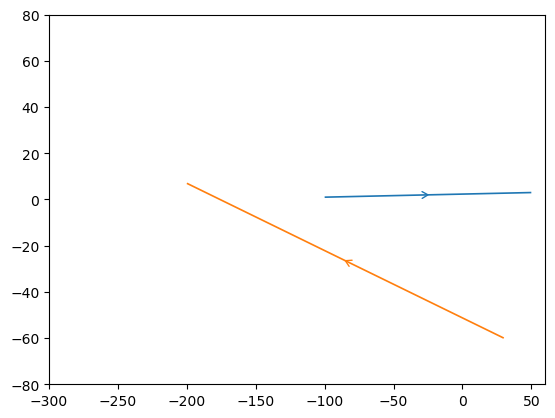

In [727]:
import matplotlib
import matplotlib.transforms as transforms

def transport_vector(fig, ax, x1, y1, x2, y2, flow, size=6, phi=np.deg2rad(30.), **kwargs):
    l = plt.plot([x1, x2], [y1, y2], lw=size/5, solid_capstyle="butt", **kwargs)
    asp = get_aspect_numerical(ax)
    s = np.sign(flow)
    theta = np.arctan2(s*(y2-y1)*asp, s*(x2-x1))
    trans = (fig.dpi_scale_trans + transforms.ScaledTranslation(x1 + (x2-x1)/2, y1 + (y2-y1)/2, ax.transData))
    plt.plot(
        np.sqrt(size*4)/72*np.array([-np.cos(theta)*np.cos(phi) - np.sin(theta)*np.sin(phi), 0, -np.cos(theta)*np.cos(phi) + np.sin(theta)*np.sin(phi)]),
        np.sqrt(size*4)/72*np.array([(-np.sin(theta)*np.cos(phi) + np.cos(theta)*np.sin(phi)), 0, (-np.sin(theta)*np.cos(phi) - np.cos(theta)*np.sin(phi))]),
        transform=trans, color=l[0].get_color(), lw=np.sqrt(size*4)/5, solid_capstyle="round", solid_joinstyle="round"
    )
    return l

fig, ax = plt.subplots(1,1)
ax.set_xlim(-300, 60)
ax.set_ylim(-80, 80)
transport_vector(fig, ax, -100, 1, 50, 3, 3)
transport_vector(fig, ax, 30, -60, -200, 7, 5)

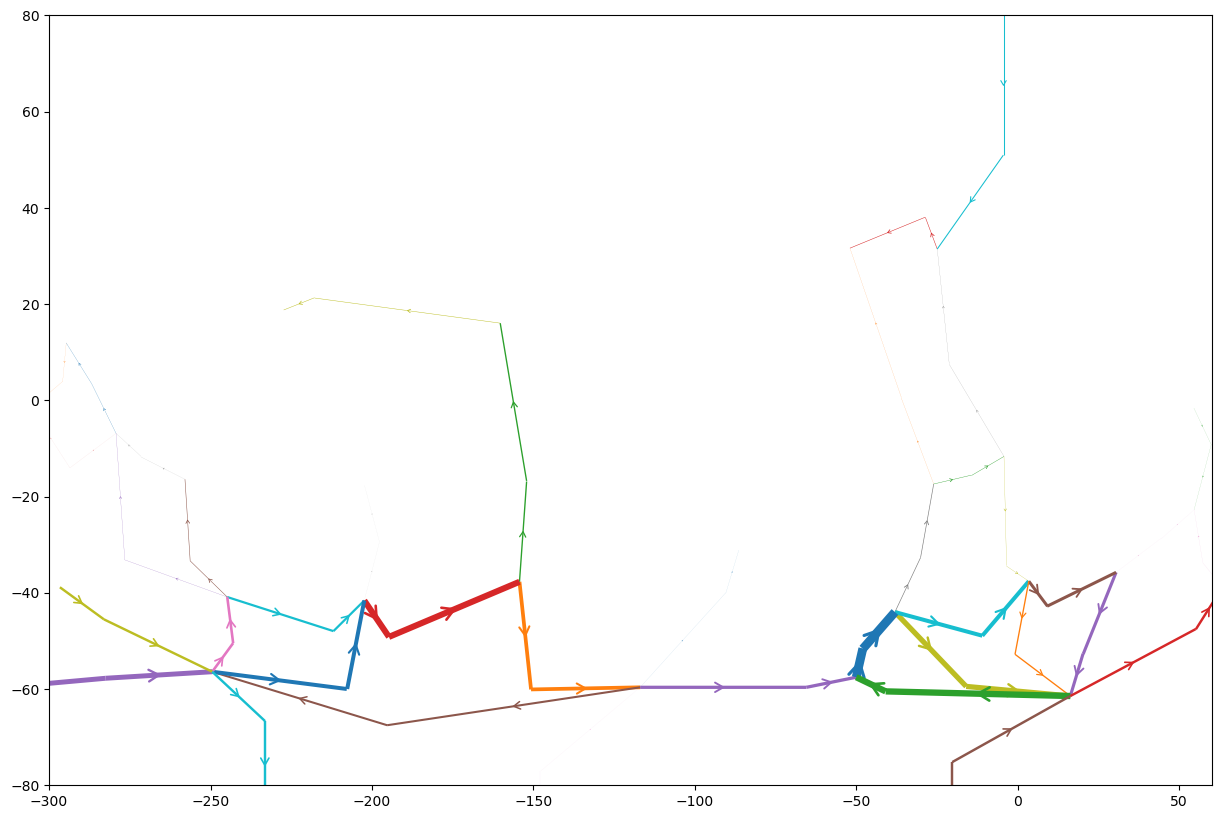

In [728]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_xlim(-300, 60)
ax.set_ylim(-80, 80)
for e, ((b1name, b2name), x) in enumerate(graph_flow.items()):
    E_coord = E_coords[(b1name, b2name)]
    l=transport_vector(fig, ax, E_coord[0][0][0], E_coord[0][1][0], E_coord[0][0][1], E_coord[0][1][1], x, size=np.abs(x))
    transport_vector(fig, ax, E_coord[1][0][0], E_coord[1][1][0], E_coord[1][0][1], E_coord[1][1][1], x, size=np.abs(x), color=l[0].get_color())

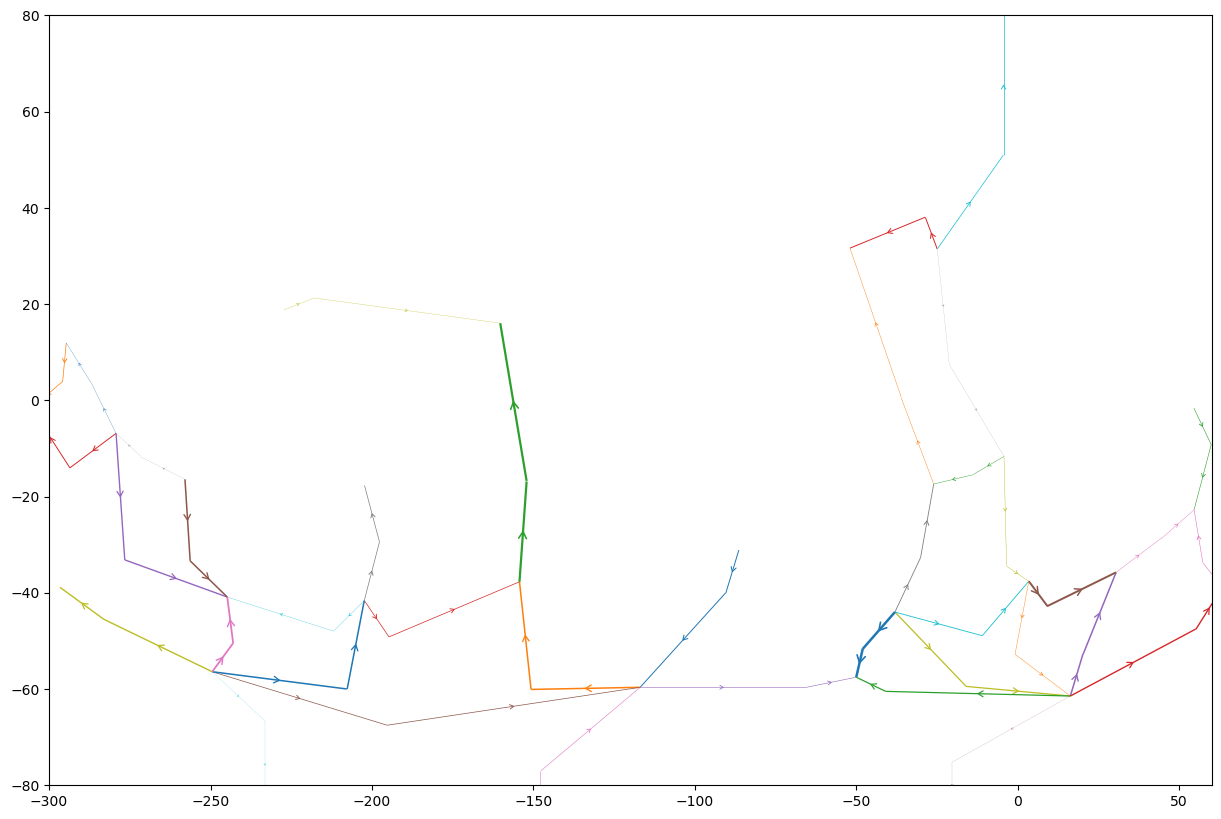

In [729]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_xlim(-300, 60)
ax.set_ylim(-80, 80)
for e, ((b1name, b2name), x) in enumerate(graph_flow.items()):
    E_coord = E_coords[(b1name, b2name)]
    x = Xdiv[e]
    l = transport_vector(fig, ax, E_coord[0][0][0], E_coord[0][1][0], E_coord[0][0][1], E_coord[0][1][1], x, size=np.abs(x))
    transport_vector(fig, ax, E_coord[1][0][0], E_coord[1][1][0], E_coord[1][0][1], E_coord[1][1][1], x, size=np.abs(x), color=l[0].get_color())

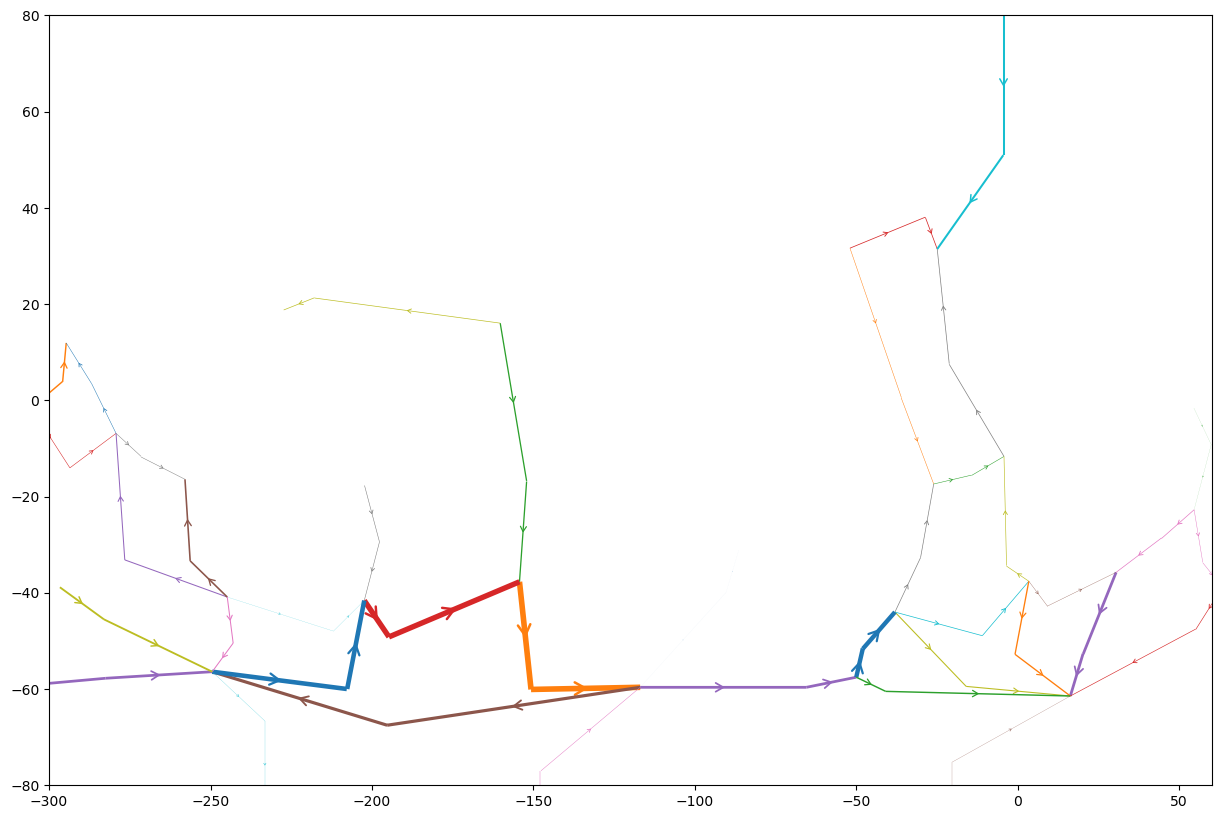

In [730]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_xlim(-300, 60)
ax.set_ylim(-80, 80)
for e, ((b1name, b2name), x) in enumerate(graph_flow.items()):
    E_coord = E_coords[(b1name, b2name)]
    x = Xrot[e]
    l = transport_vector(fig, ax, E_coord[0][0][0], E_coord[0][1][0], E_coord[0][0][1], E_coord[0][1][1], x, size=np.abs(x))
    transport_vector(fig, ax, E_coord[1][0][0], E_coord[1][1][0], E_coord[1][0][1], E_coord[1][1][1], x, size=np.abs(x), color=l[0].get_color())

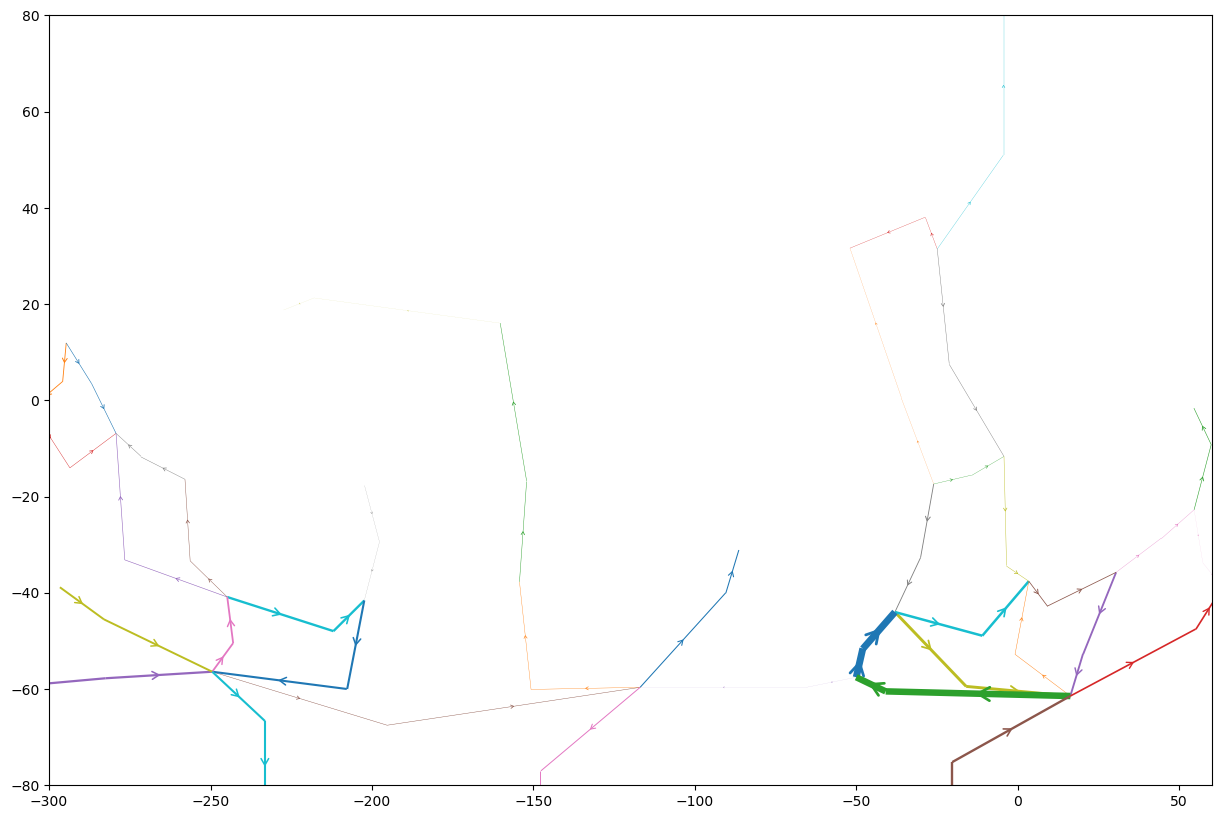

In [731]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
ax.set_xlim(-300, 60)
ax.set_ylim(-80, 80)
for e, ((b1name, b2name), x) in enumerate(graph_flow.items()):
    E_coord = E_coords[(b1name, b2name)]
    x = Xloc[e]
    l = transport_vector(fig, ax, E_coord[0][0][0], E_coord[0][1][0], E_coord[0][0][1], E_coord[0][1][1], x, size=np.abs(x))
    transport_vector(fig, ax, E_coord[1][0][0], E_coord[1][1][0], E_coord[1][0][1], E_coord[1][1][1], x, size=np.abs(x), color=l[0].get_color())

KeyboardInterrupt: 

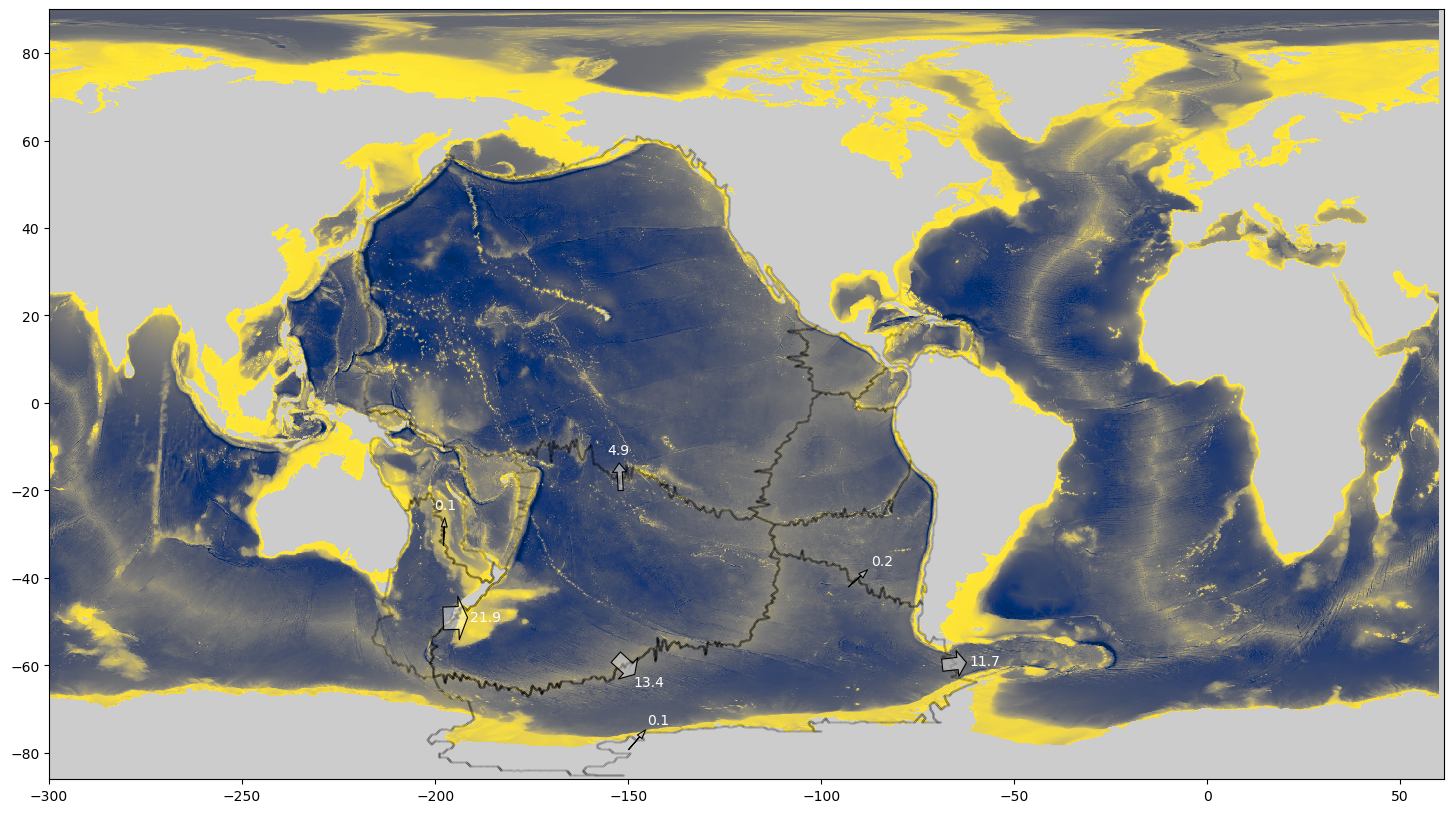

In [732]:
cmap = plt.get_cmap("cividis_r").copy()
cmap.set_bad((0.8, 0.8, 0.8))

fig, ax = plt.subplots(1,1,figsize=(18, 10))
ax.set_facecolor((0.8, 0.8, 0.8))
plt.pcolormesh(
    og['geolon_c'], og['geolat_c'],
    og['deptho'],
    cmap=cmap,
)

for b in region.Basins.values():
    plt.plot(b.lons, b.lats, "k.", markersize=0.25, alpha=0.25)


    for oname, o in region.overlaps.items():
        if b.name not in oname: continue
        if oname[0] == b.name:
            other = region.Basins[oname[1]]
        else:
            continue

        Ψexchange = np.round(b.psi_exchange[oname].isel(rho2_l=-1).values, 1)
        if Ψexchange == 0.: continue

        oidx = [oooo for ooo in o[b.name].values() for oooo in ooo]
        lon_ex = b.lons_uv[oidx[len(oidx)//2]]
        lat_ex = b.lats_uv[oidx[len(oidx)//2]]
        
        oidx_other = [oooo for ooo in o[other.name].values() for oooo in ooo]
        lon_ex_other = other.lons_uv[oidx_other[len(oidx_other)//2]]
        lat_ex_other = other.lats_uv[oidx_other[len(oidx_other)//2]]
        
        b.lon_av = reg.lon_mod(b.mask.geolon.where(b.mask), lon_ex).mean()
        b.lat_av = b.mask.geolat.where(b.mask).mean()

        other.lon_av = reg.lon_mod(other.mask.geolon.where(other.mask), lon_ex_other).mean()
        other.lat_av = other.mask.geolat.where(other.mask).mean()
        
        if np.any(np.abs(np.diff(reg.lon_mod(b.lons, lon_ex)))>180):
            b.lon_av = lon_ex
        elif np.any(np.abs(np.diff(reg.lon_mod(other.lons, lon_ex_other)))>180):
            other.lon_av = lon_ex_other
            
        if b.name == '34':
            b.lat_av = -85
        elif other.name == '34':
            other.lat_av = -85
            
        if b.name == '35':
            b.lat_av = 85
        elif other.name == '35':
            other.lat_av = 85
            
        δlon = b.lon_av - other.lon_av
        δlat = b.lat_av - other.lat_av
        scale = 3.5/np.sqrt(δlon**2 + δlat**2)
        δlon *= scale
        δlat *= scale

        s = np.sign(Ψexchange)
        xy_end = (lon_ex + s*δlon, lat_ex + s*δlat)
        xy_start = (lon_ex - s*δlon, lat_ex - s*δlat)
        xytext = (lon_ex + 2.25*s*δlon, lat_ex + 1.75*s*δlat)

        arrowprops = dict(shrink=0.05, width=0.75*np.abs(Ψexchange), headlength=6.5, headwidth=4+1.25*np.abs(Ψexchange),
                          edgecolor='black', facecolor=(1.,1.,1.,0.4), linewidth=0.8)

        plt.annotate("", xy_end, xytext=xy_start, va="center", ha="center", arrowprops=arrowprops)
        plt.annotate(f"{str(np.abs(Ψexchange))}", xytext, xytext=xytext, va="center", ha="center", color="w")

AttributeError: 'Basin' object has no attribute 'lon_av'

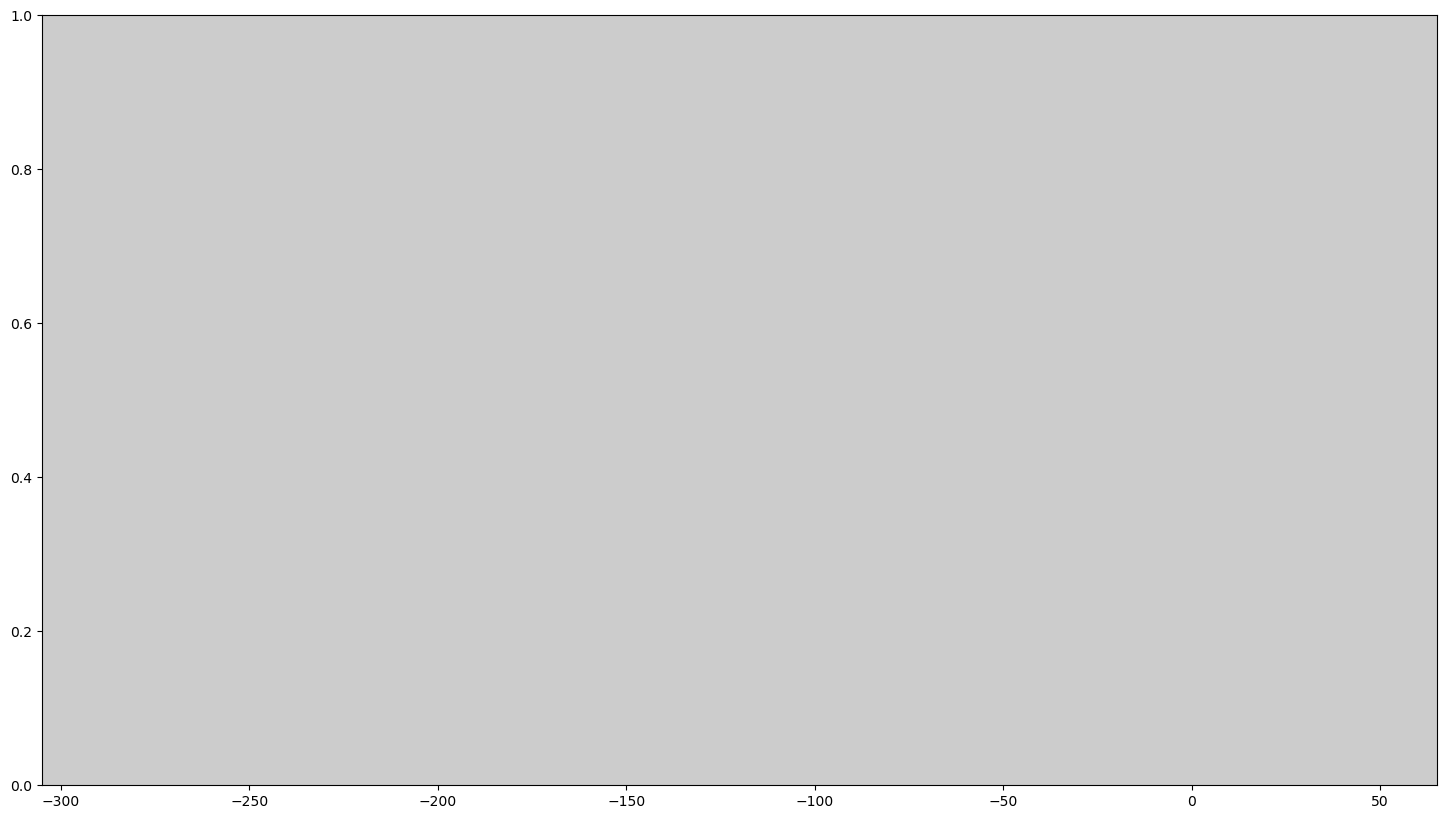

In [686]:
cmap = plt.get_cmap("cividis_r").copy()
cmap.set_bad((0.8, 0.8, 0.8))

fig, ax = plt.subplots(1,1,figsize=(18, 10))
ax.set_facecolor((0.8, 0.8, 0.8))
ax.set_xlim(-305, 65)

for b in region.Basins.values():
    for oname, o in region.overlaps.items():
        if b.name not in oname: continue
        if oname[0] == b.name:
            other = region.Basins[oname[1]]
        else:
            continue

        Ψexchange = np.round(b.psi_exchange[oname].isel(rho2_l=-1).values, 1)
        if np.abs(Ψexchange) == 0.: continue

        oidx = [oooo for ooo in o[b.name].values() for oooo in ooo]
        lon_ex = b.lons_uv[oidx[len(oidx)//2]]
        lat_ex = b.lats_uv[oidx[len(oidx)//2]]
        
        oidx_other = [oooo for ooo in o[other.name].values() for oooo in ooo]
        lon_ex_other = other.lons_uv[oidx_other[len(oidx_other)//2]]
        lat_ex_other = other.lats_uv[oidx_other[len(oidx_other)//2]]
        
        b.lon_av = reg.lon_mod(b.mask.geolon.where(b.mask), lon_ex).weighted(A).mean().values
        b.lat_av = b.mask.geolat.where(b.mask).weighted(A).mean().values

        other.lon_av = reg.lon_mod(other.mask.geolon.where(other.mask), lon_ex_other).weighted(A).mean().values
        other.lat_av = other.mask.geolat.where(other.mask).weighted(A).mean().values
        
        if np.any(np.abs(np.diff(reg.lon_mod(b.lons, lon_ex)))>180):
            b.lon_av = lon_ex
        elif np.any(np.abs(np.diff(reg.lon_mod(other.lons, lon_ex_other)))>180):
            other.lon_av = lon_ex_other
            
        if b.name == '34':
            b.lat_av = -85
        elif other.name == '34':
            other.lat_av = -85
            
        if b.name == '35':
            b.lat_av = 80
        elif other.name == '35':
            other.lat_av = 80

        δlon = b.lon_av - other.lon_av
        δlat = b.lat_av - other.lat_av
        δ = 3.5
        scale = δ/np.sqrt(δlon**2 + δlat**2)
        δlon *= scale
        δlat *= scale

        s = np.sign(Ψexchange)
        xy_end = (lon_ex + s*δlon, lat_ex + s*δlat)
        xy_start = (lon_ex - s*δlon, lat_ex - s*δlat)
        xytext = (lon_ex + 2.25*s*δlon, lat_ex + 1.75*s*δlat)

        scale_bar = 0.5
        plt.plot([b.lon_av, lon_ex, other.lon_av], [b.lat_av, lat_ex, other.lat_av],
                 lw=np.abs(Ψexchange)*scale_bar, color=make_color_transparent("C0", 0.5), solid_capstyle="butt", solid_joinstyle="bevel")
        
        δlon1, δlat1 = lon_ex-b.lon_av, lat_ex-b.lat_av
        lon1, lat1 = b.lon_av+δlon1/2., b.lat_av+δlat1/2.
        
        scale_arrows = np.abs(Ψexchange)*scale_bar/3+2.
        lw_arrows = np.sqrt(np.abs(Ψexchange)*scale_bar/3+0.5)
        
        ϕ = np.deg2rad(30.)
        θ = np.arctan2(-s*δlat1, -s*δlon1)
        plt.plot(
            lon1+scale_arrows*np.array([-np.cos(θ)*np.cos(ϕ) - np.sin(θ)*np.sin(ϕ), 0, -np.cos(θ)*np.cos(ϕ) + np.sin(θ)*np.sin(ϕ)]),
            lat1+scale_arrows*np.array([-np.sin(θ)*np.cos(ϕ) + np.cos(θ)*np.sin(ϕ), 0, -np.sin(θ)*np.cos(ϕ) - np.cos(θ)*np.sin(ϕ)]),
            color=make_color_transparent("C0", 0.5), lw=lw_arrows, solid_capstyle="round", solid_joinstyle="round"
        )
        
        δlon2, δlat2 = other.lon_av-lon_ex, other.lat_av-lat_ex
        lon2, lat2 = lon_ex+δlon2/2., lat_ex+δlat2/2.
        
        ϕ = np.deg2rad(30.)
        θ = np.arctan2(-s*δlat2, -s*δlon2)
        plt.plot(
            lon2+scale_arrows*np.array([-np.cos(θ)*np.cos(ϕ) - np.sin(θ)*np.sin(ϕ), 0, -np.cos(θ)*np.cos(ϕ) + np.sin(θ)*np.sin(ϕ)]),
            lat2+scale_arrows*np.array([-np.sin(θ)*np.cos(ϕ) + np.cos(θ)*np.sin(ϕ), 0, -np.sin(θ)*np.cos(ϕ) - np.cos(θ)*np.sin(ϕ)]),
            color=make_color_transparent("C0", 0.5), lw=lw_arrows, solid_capstyle="round", solid_joinstyle="round"
        )
        
    psi = b.psi_net.isel(rho2_l=-1).values
    print(b.name, psi, (b.lon_av, b.lat_av))
    for x_offset in [-360, 0, 360]:
        plot_pagenormal_vector(fig, ax, (b.lon_av+x_offset, b.lat_av), sign=np.sign(psi), radius=np.abs(psi)*3)

for b in region.Basins.values():
    plt.plot(b.lons, b.lats, "k.", markersize=0.25, alpha=0.2)
    plt.plot(b.lons+360., b.lats, "k.", markersize=0.25, alpha=0.2)
    plt.plot(b.lons-360., b.lats, "k.", markersize=0.25, alpha=0.2)
        
plt.plot([], [], "C0-", lw=0.1*scale_bar, label="0.2 Sv")
plt.plot([], [], "C0-", lw=1*scale_bar, label="2 Sv")
plt.plot([], [], "C0-", lw=10*scale_bar, label="20 Sv")
plt.legend(loc="upper left")

In [170]:
import matplotlib
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

def make_color_transparent(color, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(matplotlib.colors.to_rgba(color), (1., 1., 1.))]

def plot_circle(fig, ax, xy, radius=10, **kwargs):
    trans = (fig.dpi_scale_trans + transforms.ScaledTranslation(xy[0], xy[1], ax.transData))
    ellipse = Ellipse((0, 0), radius*2/72, radius*2/72, angle=0, transform=trans, zorder=2, **kwargs)
    ax.add_artist(ellipse)

def plot_X(fig, ax, xy, radius=10, angle = np.pi/4, **kwargs):
    trans = (fig.dpi_scale_trans + transforms.ScaledTranslation(xy[0], xy[1], ax.transData))
    ax.plot((radius/72)*np.array([-np.cos(angle), np.cos(angle)]), (radius/72)*np.array([np.sin(angle), -np.sin(angle)]), solid_capstyle="butt", transform=trans, **kwargs)
    ax.plot((radius/72)*np.array([-np.cos(angle), np.cos(angle)]), (radius/72)*np.array([-np.sin(angle), np.sin(angle)]), solid_capstyle="butt", transform=trans, **kwargs)

def plot_pagenormal_vector(fig, ax, xy, sign=1, radius=10, colors={1:"C3", -1:"C0"}, **kwargs):
    if sign==0:
        return
    
    reset_aspect = False
    if ax.get_aspect()=="auto":
        ax.set_aspect(get_aspect_numerical(ax))
        reset_aspect = True
        
    color = colors[sign]
    plot_circle(fig, ax, xy, radius=radius, facecolor=make_color_transparent(color, 0.15))
    if sign==1:
        plot_circle(fig, ax, xy, radius=radius/10 + np.sqrt(radius/5), facecolor=color)
    elif sign==-1:
        plot_X(fig, ax, xy, radius=radius, color=color, linewidth=np.sqrt(radius/5))
    else:
        raise ValueError("Keyword argument sign must be '1', '-1', or '0'.")
    plot_circle(fig, ax, xy, radius=radius, facecolor=(1., 1., 1., 0.), edgecolor=color, linewidth=np.sqrt(radius/5))
    
    if reset_aspect:
        ax.set_aspect("auto")
        
def get_aspect_numerical(ax=None):
    if ax is None:
        ax = plt.gca()
    fig = ax.figure

    ll, ur = ax.get_position() * fig.get_size_inches()
    width, height = ur - ll
    axes_ratio = height / width
    aspect = axes_ratio / ax.get_data_ratio()

    return aspect

(-1.0, 1.0)

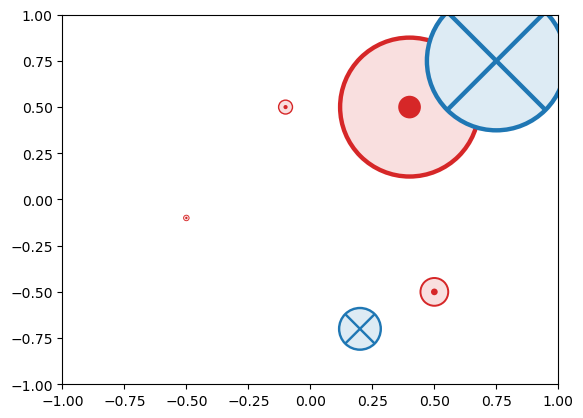

In [338]:
fig, ax=plt.subplots(1,1)
plot_pagenormal_vector(fig, ax, (0.5, -0.5))
plot_pagenormal_vector(fig, ax, (0.2, -0.7), sign=-1, radius=15)
plot_pagenormal_vector(fig, ax, (-0.1, 0.5), sign=1, radius=5)
plot_pagenormal_vector(fig, ax, (-0.5, -0.1), sign=1, radius=2)
plot_pagenormal_vector(fig, ax, (0.4, 0.5), sign=1, radius=50)
plot_pagenormal_vector(fig, ax, (0.75, 0.75), sign=-1, radius=50)
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [307]:
b = region.Basins['24']

In [12]:
b.psi_exchange[('23','24')].isel(rho2_l=-1)

<xarray.DataArray 'conv_mass_transport' ()>
array(2.3117292, dtype=float32)
Coordinates:
    rho2_l   float64 1.039e+03
    time     object 0350-07-02 12:00:00

### Hodge decomposition

Let $f(v_{i}) = 1$ for all vertices but $X(i,j)$ denote transports (in units of Sverdrup) from vertex $i$ to $j$.

In [1]:
import numpy as np
import scipy

In [567]:
X=[1., 1., 1., 1., 1., 1., 1.]

# The gradient matrix
# columns are vertices (NV); rows labeled edges (number NE)
# entry (i,j) is +1 if edge i points to vertex j, -1 otherwise
A = np.matrix([
    [-1, 1, 0, 0, 0, 0],
    [0, -1, 1, 0, 0, 0],
    [0, 0, -1, 1, 0, 0],
    [1, 0, 0, -1, 0, 0],
    [0, 0, -1, 0, 1, 0],
    [0, 0, 0, 0, -1, 1],
    [0, 0, -1, 0, 0, 1]
])
# The graph Laplacian
L = np.transpose(A)*A

# The curl matrix
B = np.matrix([0, 0, 0, 0, 1, 1, -1])

# The graph Helmholtzian
H = A*np.transpose(A) + np.transpose(B)*B

In [2]:
scipy.optimize.lsq_linear

<function scipy.optimize._lsq.lsq_linear.lsq_linear(A, b, bounds=(-inf, inf), method='trf', tol=1e-10, lsq_solver=None, lsmr_tol=None, max_iter=None, verbose=0, *, lsmr_maxiter=None)>

In [569]:
tmp = scipy.linalg.null_space(L)

In [ ]:
tmp

In [560]:
import scipy
E_rot = scipy.linalg.null_space(H)

In [564]:
scipy.linalg.null_space(A)

array([[-0.40824829],
       [-0.40824829],
       [-0.40824829],
       [-0.40824829],
       [-0.40824829],
       [-0.40824829]])

In [550]:
B

matrix([[ 0,  0,  0,  0,  1,  1, -1]])

In [523]:
H.shape

(7, 7)

In [512]:
L.shape

(6, 6)

In [502]:
A.shape

(7, 6)

In [503]:
H.shape

(7, 7)

In [501]:
def grad(A):
    for i in A.shape[0]:
        for j in A.shape[1]:
            if 

matrix([[ 2, -1,  0, -1,  0,  0,  0],
        [-1,  2, -1,  0, -1,  0, -1],
        [ 0, -1,  2, -1,  1,  0,  1],
        [-1,  0, -1,  2,  0,  0,  0],
        [ 0, -1,  1,  0,  3,  0,  0],
        [ 0,  0,  0,  0,  0,  3,  0],
        [ 0, -1,  1,  0,  0,  0,  3]])

In [482]:
import scipy

In [483]:
tmp = np.linalg.eig(L)

In [484]:
tmp[0]

array([ 5.23606798e+00,  3.00000000e+00, -3.48195594e-16,  7.63932023e-01,
        2.00000000e+00,  3.00000000e+00])

In [476]:
L

matrix([[ 2, -1,  0, -1,  0,  0],
        [-1,  2, -1,  0,  0,  0],
        [ 0, -1,  4, -1, -1, -1],
        [-1,  0, -1,  2,  0,  0],
        [ 0,  0, -1,  0,  2, -1],
        [ 0,  0, -1,  0, -1,  2]])

In [475]:
np.real(tmp[1])

matrix([[ 1.95439508e-01, -7.30296743e-01,  4.08248290e-01,
          5.11667274e-01,  1.99051133e-16, -3.32986653e-02],
        [-3.16227766e-01,  3.65148372e-01,  4.08248290e-01,
          3.16227766e-01, -7.07106781e-01,  1.66493326e-02],
        [ 8.27895040e-01,  3.65148372e-01,  4.08248290e-01,
         -1.20788258e-01,  1.14967359e-16,  1.66493326e-02],
        [-3.16227766e-01,  3.65148372e-01,  4.08248290e-01,
          3.16227766e-01,  7.07106781e-01,  1.66493326e-02],
        [-1.95439508e-01, -1.82574186e-01,  4.08248290e-01,
         -5.11667274e-01, -6.46268351e-17, -7.14696027e-01],
        [-1.95439508e-01, -1.82574186e-01,  4.08248290e-01,
         -5.11667274e-01,  3.65584587e-16,  6.98046694e-01]])